<a href="https://colab.research.google.com/github/mohammedterry/ANNs/blob/master/ANN_NeuroEvo_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -O https://pmcvariety.files.wordpress.com/2018/04/twitter-logo.jpg?w=100&h=100&crop=1
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3593  100  3593    0     0  15758      0 --:--:-- --:--:-- --:--:-- 15758
 sample_data  'twitter-logo.jpg?w=100'


In [0]:
from PIL import Image
image = Image.open('twitter-logo.jpg?w=100')

In [0]:
import numpy as np
image_array = np.asarray(image)

In [0]:
training_inputs,training_outputs = [],[]
for row,rgbs in enumerate(image_array):
  for column,rgb in enumerate(rgbs):
    training_inputs.append(np.array([row,column]))
    r,g,b = rgb
    training_outputs.append(np.array([r/255,g/255,b/255]))

# NeuroEvolution

In [0]:
import numpy as np
import random

class FFNN:
  def __init__(self, weights):
    self.weights = weights
  
  def _f(self,x): #activation function: sigmoid
    return 1. / (1. + np.exp(-x))
  
  def __call__(self, x): #forward pass through each layer in the deep ffnn
    for w in self.weights:
      x = self._f(x @ w)
    return x

class GA:
  evolutionary_history = [0]
  #hyperparameters
  n_hidden = 50
  alpha = .01
  max_generations = 300
  population_size = 40
  p_perturb_weight = .5
  p_mutate_weight = .05
  p_mutate_layer = .5
  p_add_layer = .3

  def __init__(self,n_inputs,n_outputs,x_test,y_test):
    self.n_inputs, self.n_outputs = n_inputs,n_outputs 
    self.genomes = [[np.random.randn(self.n_inputs,self.n_hidden),np.random.randn(self.n_hidden,self.n_outputs)] for _ in range(self.population_size)]  #each genome is a 2D matrix of synapse weights for each layer in ffnn
    self.x_test = x_test
    self.y_test = y_test
    
  def fitness(self, weights):
    ann = FFNN(weights)
    y_predicted = np.array([ann(x) for x in self.x_test])
    rms_error = np.sum((self.y_test - y_predicted)**2)**.5 / len(self.y_test)
    return 1-rms_error
  
  def rank(self,genomes):
    self.fitnesses = [self.fitness(genome) for genome in genomes]
    self.evolutionary_history.append( max(self.fitnesses) )
    return [genomes[i] for _,i in sorted(zip(self.fitnesses,[i for i in range(len(self.fitnesses))]), reverse=True)] #rank genomes by fitness

  def mutate(self,genomes):
    def noise(x):
      return x + np.random.uniform(-self.alpha,self.alpha) if np.random.random() <= self.p_perturb_weight else np.random.uniform(-1,1) if np.random.random() <= self.p_mutate_weight else x
    noise = np.vectorize(noise) 

    for i,weights in enumerate(genomes):   
      genomes[i] = [noise(layer) if random.random() <= self.p_mutate_layer else layer for layer in weights] #change some weights
      if np.random.random() <= self.p_add_layer: #add another hidden layer 
        pointer = np.random.randint(1,len(weights)) #add it inbetween the input and output layers
        genomes[i] = weights[:pointer] + [np.random.randn(self.n_hidden,self.n_hidden)] + weights[pointer:]                  
    return genomes
  
  def crossover(self,genome1,genome2): #one-point crossover
    pointer = np.random.randint(1,self.n_hidden)
    for i in range(1,min(len(genome1),len(genome2))-1):
      _genome1 = np.concatenate( (genome1[i][:pointer],genome2[i][pointer:]) )
      _genome2 = np.concatenate( (genome2[i][:pointer],genome1[i][pointer:]) )
      genome1[i],genome2[i] = _genome1,_genome2
    return genome1, genome2
  
  def mate(self,genome1,genome2):
    child1,child2 = self.crossover(genome1,genome2)
    return genome1, genome2, child1, child2 # returns x2 parents & x2 children (i.e. mixtures of both parents)
  
  def g_algorithm(self):
    self.best_genome = self.rank(self.genomes)[0]
    fitness_total = sum(self.fitnesses)
    elite_indexes = np.random.choice(len(self.genomes), (self.population_size // 4) -1, p= [f/fitness_total for f in self.fitnesses]) #randomly sample quarter of new population from the old using fitness to determine probability of being sampled 
    elites = [self.genomes[i] for i in elite_indexes]
    offspring = [child for parent1,parent2 in zip(elites,random.sample(elites, len(elites))) for child in self.mate(parent1,parent2) ]  #elite's offspring replace population (4 children for every genome)
    self.genomes = self.mutate(offspring) + [self.best_genome] + [[np.random.randn(self.n_inputs,self.n_hidden), np.random.randn(self.n_hidden,self.n_outputs)] for _ in range(3)] #new population is offspting and the best parent (in case all children are worse) and three new random genomes (in case the current gene pool simply isnt good enough)
    
  def evolve(self):
    for generation in range(self.max_generations):
      self.g_algorithm()
      print(generation, self.evolutionary_history[-1])
      

In [213]:
g = GA(2,3,training_inputs,training_outputs)
g.evolve()
best_weight = g.best_genome

0 0.9958191147630706
1 0.9958191147630706
2 0.9958191147630706
3 0.9961740432253259
4 0.9941454418966992
5 0.9953610796863951
6 0.9953610796863951
7 0.9954781038250122
8 0.9959636815175132
9 0.9959636815175132
10 0.9959636815175132
11 0.9959636815175132
12 0.9961503761795713
13 0.9961503761795713
14 0.9961503761795713
15 0.9947939176995936
16 0.9959053009747209
17 0.9959572716074243
18 0.996001112794969
19 0.996001112794969
20 0.996001112794969
21 0.996001112794969
22 0.996001112794969
23 0.9963397549737187
24 0.9964053913140558
25 0.9964053913140558
26 0.9964053913140558
27 0.9964053913140558
28 0.995260573092088
29 0.9961412979557849
30 0.9961412979557849
31 0.9961412979557849
32 0.9961412979557849
33 0.9961412979557849
34 0.9961412979557849
35 0.9958139094708545
36 0.9958139094708545
37 0.9958139094708545
38 0.9958139094708545
39 0.9958139094708545
40 0.9943540235614925
41 0.9954200351115541
42 0.9954200351115541
43 0.9954200351115541
44 0.9959233183233593
45 0.9959233183233593
46 0

KeyboardInterrupt: ignored

Text(0, 0.5, 'fitness')

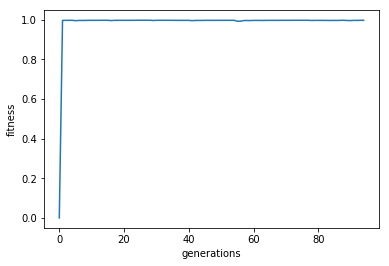

In [215]:
import matplotlib.pyplot as plt
plt.plot(g.evolutionary_history)
plt.xlabel('generations')
plt.ylabel('fitness')

In [216]:
best_weight

[array([[-0.1646029 ,  0.27278961,  0.50214387, -1.18060223, -0.77355618,
         -0.73607221, -0.54079667, -0.52399549, -0.14448807,  0.07536777,
         -0.76558429,  1.41955381,  0.32693218,  0.54418056,  1.48755906,
          0.21565202,  0.16200531, -0.03888463,  0.46968643,  0.35452857,
          1.02394624,  0.2067339 ,  0.06635742, -0.26005539, -0.68444758,
          1.0728887 ,  0.84828345,  1.13475338,  0.2892592 , -0.82602853,
         -0.24298598, -0.16891262,  0.19882707,  0.05251991, -0.55510693,
          0.78444733,  0.12601298,  0.35413196,  0.10604834, -0.62986796,
          0.59387299,  0.84137599,  0.72053555, -0.11495378, -0.77840987,
         -0.68877295, -0.56026206,  0.94744728,  1.66620297,  1.00741944],
        [-0.10148596,  0.1519964 ,  0.37730545, -1.30626222,  1.17973977,
         -0.32273358,  0.18283387, -1.04193286, -0.27008665, -0.75384469,
         -0.6044304 ,  2.29805782, -1.42523413,  1.1704129 ,  0.50473445,
         -2.25305715,  0.64388161, -0

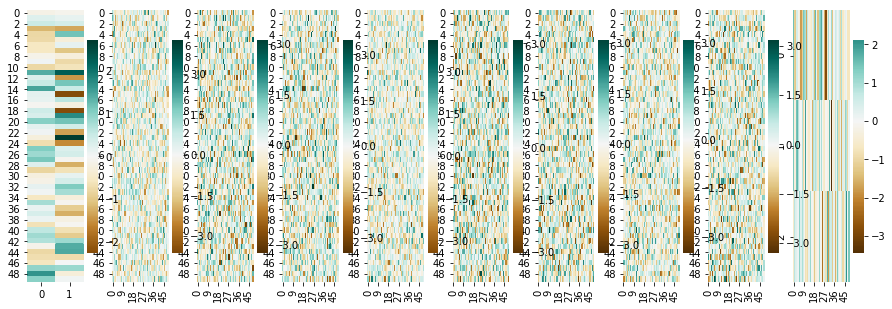

In [217]:
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, len(best_weight),figsize=(15, 5) )
import pandas as pd
import seaborn as sns
for layer in range(len(best_weight)):
  sns.heatmap(pd.DataFrame({f'{i}':w for i,w in enumerate(best_weight[layer])}),center=0,cmap="BrBG",ax=axes[layer])

In [218]:
evolved_ann = FFNN(best_weight)
evolved_ann([1,1])

array([0.90773067, 0.93874126, 0.73090911])

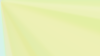

In [219]:
predicted_outputs = evolved_ann(training_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,rgbs in enumerate(predicted_image_array):
  for column in range(len(rgbs)):
    r,g,b = predicted_outputs[i]
    predicted_image_array[row][column] = [r*255,g*255,b*255]
    i += 1
Image.fromarray(predicted_image_array)

# Extreme Learning Machine

In [0]:
import numpy as np

class ELM:
  def __init__(self, n_inputs: int, n_hidden = 3000):
    self.random_weights = np.random.normal(size=[n_inputs, n_hidden])
    
  def learn(self, X: np.ndarray, Y: np.ndarray):
    H = self._hidden_layer(X)
    self.output_weights = np.linalg.pinv(H) @ Y
    
  def _f(self, x: np.ndarray): 
    return 1. / (1. + np.exp(-x)) #activation function: sigmoid
    
  def _hidden_layer(self, inputs: np.ndarray): 
    return self._f(inputs @ self.random_weights)
  
  def _output_layer(self, hidden: np.ndarray): 
    return hidden @ self.output_weights
  
  def __call__(self, inputs: np.ndarray):  #infer
    return self._output_layer(self._hidden_layer(inputs))

In [0]:
elm = ELM(2)
elm.learn(np.array(training_inputs), np.array(training_outputs))

In [0]:
elm([1,1])

array([0.95012379, 0.94977713, 0.94932604])

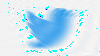

In [0]:
predicted_outputs = elm(training_inputs)

predicted_image_array = np.zeros_like(image_array)
i = 0
for row,rgbs in enumerate(predicted_image_array):
  for column in range(len(rgbs)):
    r,g,b = predicted_outputs[i]
    predicted_image_array[row][column] = [r*255,g*255,b*255]
    i += 1
Image.fromarray(predicted_image_array)